<a href="https://colab.research.google.com/github/CLiz17/densenet-deepfake/blob/main/kaggle_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


List of categories =  ['df', 'real'] 

No. of categories =  2
No. of images loaded =  2007 
No. of labels loaded =  2007
<class 'list'> <class 'list'>
Images shape =  (2007, 150, 150, 3) 
Labels shape =  (2007,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
'n' values before shuffling =  [   0    1    2 ... 2004 2005 2006]

'n' values after shuffling =  [1960  526  393 ...  860 1459 1126]
Images shape after shuffling =  (2007, 150, 150, 3) 
Labels shape after shuffling =  (2007,)
x_train shape =  (1605, 150, 150, 3)
y_train shape =  (1605,)

x_test shape =  (402, 150, 150, 3)
y_test shape =  (402,)
Found 1506 images belonging to 2 classes.
Found 501 images belonging to 2 classes.
29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                          

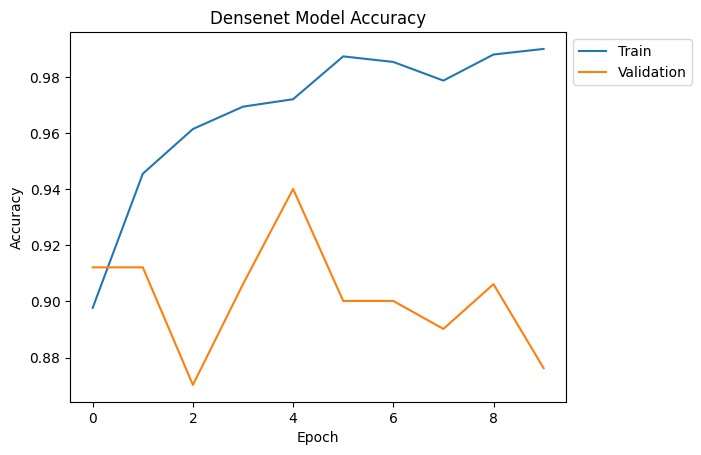

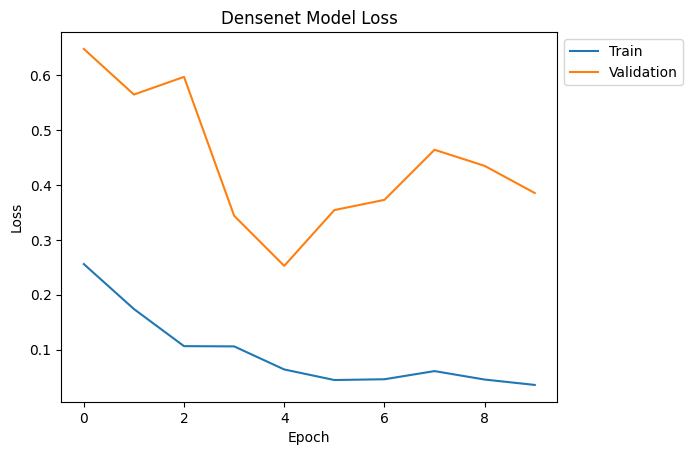

16/16 [==============================] - 39s 2s/step


<Axes: >

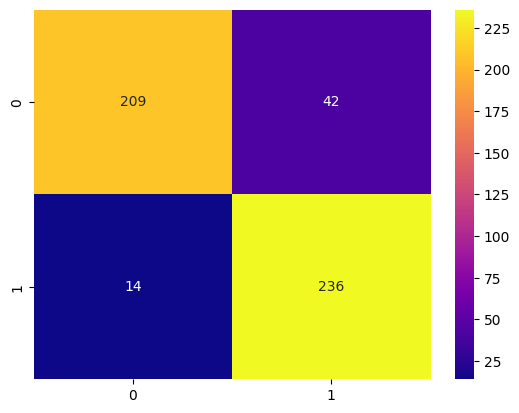

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Dense,Activation
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from sklearn import metrics

fpath = "/content/drive/MyDrive/kaggle-dataset"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_array = Image.fromarray(img, 'RGB')

            resized_img = img_array.resize((150, 150))

            img_lst.append(np.array(resized_img))

            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,validation_split = 0.25
 )

train_generator = train_datagen.flow_from_directory(
    fpath,
    target_size = (150,150),
    batch_size = 32,subset = 'training',
     class_mode = 'binary')

validation_generator = train_datagen.flow_from_directory(
    fpath,
    target_size = (150,150),
    batch_size = 32,subset = 'validation',
    class_mode = 'binary',shuffle=False)

dense_model = DenseNet121(input_shape=(150,150,3),include_top=False,weights="imagenet")
for layer in dense_model.layers:
    layer.trainable=False
model=Sequential()
model.add(dense_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.summary()

OPT    = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

hist = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
)

model.save('model_weights')

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Densenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Densenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

y_true = validation_generator.classes
y_pred = (model.predict(validation_generator) > 0.5).astype("int32")
cm=confusion_matrix(y_true, y_pred)

sns.heatmap(cm,cmap="plasma",fmt="d",annot=True)

In [3]:
#Calculations
def calculate_metrics(cm):
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    return sensitivity, specificity, accuracy, precision, f1_score

sensitivity, specificity, accuracy, precision, f1_score = calculate_metrics(cm)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1_score)

Sensitivity: 0.944
Specificity: 0.8326693227091634
Accuracy: 0.8882235528942116
Precision: 0.8489208633093526
F1 Score: 0.8939393939393939


1/1 [==============================] - 3s 3s/step
The image is a deepfake 


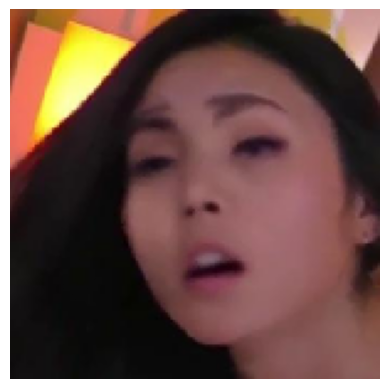

In [14]:
# Testing
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model("/content/model_weights")

def predict(filepth):
    img = load_img(filepth, target_size=(150,150))
    img = img_to_array(img)
    img = img / 255
    plt.imshow(img)
    plt.axis('off')
    img = np.expand_dims(img,axis=0)
    answer = model.predict(img)
    if answer < 0.5:
        print("The image is a deepfake ")
    else:
        print("The image is of a real person ")

predict("/content/drive/MyDrive/kaggle-dataset/df/114_324.jpg")

1/1 [==============================] - 0s 316ms/step


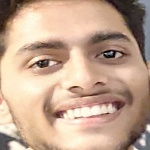

File: 005_real.jpg
The image is of a real person
1/1 [==============================] - 0s 333ms/step


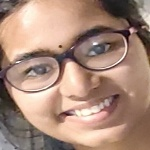

File: 006_real.jpg
The image is of a real person
1/1 [==============================] - 0s 264ms/step


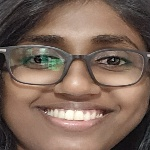

File: 004_real.jpg
The image is of a real person
1/1 [==============================] - 0s 311ms/step


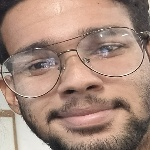

File: 002_real.jpg
The image is of a real person
1/1 [==============================] - 0s 285ms/step


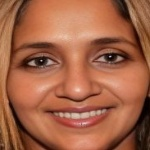

File: 002_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 302ms/step


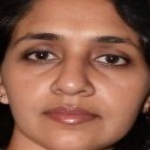

File: 004_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 376ms/step


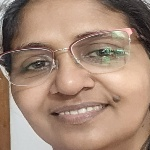

File: 003_real.jpg
The image is of a real person
1/1 [==============================] - 0s 319ms/step


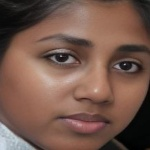

File: 005_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 208ms/step


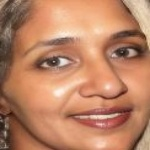

File: 003_dfake.jpg
The image is of a real person
1/1 [==============================] - 0s 304ms/step


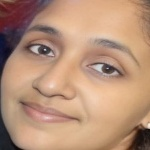

File: 001_dfake.jpg
The image is of a real person


In [15]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display

def predict(file_path):
    img = load_img(file_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    result = "The image is a deepfake" if prediction < 0.5 else "The image is of a real person"
    return result, img

dataset_folder = "/content/drive/MyDrive/test-dataset"

all_files = os.listdir(dataset_folder)

selected_files = random.sample(all_files, k=10)

for file_name in selected_files:
    file_path = os.path.join(dataset_folder, file_name)
    result, img = predict(file_path)
    display(img)
    print("File:", file_name)
    print(result)